## W pdfs

In [9]:
from scipy import ndimage, interpolate
import pyart
from netCDF4 import Dataset
import numpy as np
from datetime import datetime, timedelta
import glob
from copy import deepcopy
from matplotlib import pyplot as plt
import math
%matplotlib inline

In [2]:
def area_anal(pixel_area, rr_x, rain_rates): 
    A_rainrate = np.zeros(rr_x.shape) 
    N_rainrate = np.zeros(rr_x.shape) 
    Rm_rainrate = np.zeros(rr_x.shape) 
    for i in range(len(rr_x)): 
        b_fld = np.zeros(rain_rates.shape) 
        b_fld[rain_rates > rr_x[i]] = 1.0 
        regions, N_rainrate[i] = ndimage.label(b_fld) 
        try: 
            A_rainrate[i] = (len(np.where( regions > 0.5)[0]) * pixel_area) 
            Rm_rainrate[i] = rain_rates[ np.where(regions > 0.5)].mean() 
        except IndexError: 
            A_rainrate[i] = 0.0 
            Rm_rainrate[i] = 0.0 
    return N_rainrate, A_rainrate, Rm_rainrate

In [7]:
data_path = 'C:/Users/rjackson/Documents/data/multidop_grids/'
wrf_file = 'C:/Users/rjackson/Documents/data/wrftestdata/wrfout_d01_2006-01-20_000000'
conv_strat_path = 'C:/Users/rjackson/Documents/data/conv_stratiform/'

# get_radar_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_dda_times(start_year, start_month, start_day,
                  start_hour, start_minute, end_year,
                  end_month, end_day, end_hour, 
                  end_minute, minute_interval=5):

    start_time = datetime(start_year,
                      start_month,
                      start_day,
                      start_hour,
                      start_minute,
                      )
    end_time = datetime(end_year,
                      end_month,
                      end_day,
                      end_hour,
                      end_minute,
                      )

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
 
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path +
                      'cf_compliant_grid' +
                      year_str +
                      month_str +
                      day_str +
                      '*.nc')
    
    
        print('Looking for files with format ' + format_str)
          
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-15:-3]
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[8:10]
        minute_str = date_str[10:12]
        second_str = '00'
             
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            0)
        time_list.append(cur_time)
        
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
   
    for times in time_list_sorted:         
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
                           
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_grid_from_dda(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path +
                    'cf_compliant_grid' +
                     year_str +
                     month_str +
                     day_str +
                     hour_str +
                     minute_str + '.nc')
    
    radar = pyart.io.read_grid(file_name_str)
    return radar

def get_bca(grid):
    berr_origin = [-12960.1,-23091.1]
    x,y = np.meshgrid(grid.x['data'], grid.y['data'])
    a = np.sqrt(np.multiply(x,x)+np.multiply(y,y))
    b = np.sqrt(pow(x-berr_origin[0],2)+pow(y-berr_origin[1],2))
    c = np.sqrt(berr_origin[0]*berr_origin[0]+berr_origin[1]*berr_origin[1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-berr_origin[1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))

In [4]:
times = get_dda_times(2006, 1, 20, 0, 1,
                      2006, 1, 20, 3, 2)

We are about to load grid files for 1 days
Looking for files with format C:/Users/rjackson/Documents/data/multidop_grids/cf_compliant_grid20060120*.nc


In [62]:
reflectivity_bins = np.arange(0,60,5)
w_bins = np.arange(0,50,5)

N_ref = np.zeros((len(times),len(reflectivity_bins)))
A_ref = np.zeros((len(times),len(reflectivity_bins)))
Z_ref = np.zeros((len(times),len(reflectivity_bins)))
Mean_ref = np.zeros(len(times))

N_w = np.zeros((len(times),len(w_bins)))
A_w = np.zeros((len(times),len(w_bins)))
Z_w = np.zeros((len(times),len(w_bins)))
Mean_w = np.zeros(len(times))

N_refwrf = np.zeros((len(times),len(reflectivity_bins)))
A_refwrf = np.zeros((len(times),len(reflectivity_bins)))
Z_refwrf = np.zeros((len(times),len(reflectivity_bins)))
Mean_refwrf = np.zeros(len(times))

N_wwrf = np.zeros((len(times),len(w_bins)))
A_wwrf = np.zeros((len(times),len(w_bins)))
Z_wwrf = np.zeros((len(times),len(w_bins)))
wrf_radars = []

Mean_wwrf = np.zeros(len(times))
w_level = 5
i = 0
wrf_cdf = Dataset(wrf_file, mode='r')
Z_wrf = wrf_cdf.variables['REFL_10CM'][:,:,:,:]
Lat_wrf = wrf_cdf.variables['XLAT'][:,:,:]
Lon_wrf = wrf_cdf.variables['XLONG'][:,:,:]
W_wrf = wrf_cdf.variables['W'][:]
PH_wrf = wrf_cdf.variables['PH'][:]
PHB_wrf = wrf_cdf.variables['PHB'][:]
ETA_wrf = wrf_cdf.variables['ZNW'][:]
P_wrf = wrf_cdf.variables['PB'][:]
alt_wrf = np.zeros(PH_wrf.shape)
# Calculate height from WRF
array_shape = PH_wrf.shape
alt_wrf = (PH_wrf+PHB_wrf)/9.81

[     0.            101.51908875    202.95535278    304.36740112
    405.78729248    507.20135498    608.58325195    709.92236328
    811.21563721    912.41217041   1013.48590088   1114.42480469
   1215.23583984   1315.93493652   1416.54016113   1517.06433105
   1617.53649902   1736.83740234   1874.97607422   2031.94580078
   2207.72924805   2402.34277344   2615.79370117   2848.02661133
   3099.05615234   3349.93823242   3600.70263672   3851.36352539
   4101.93701172   4352.40820312   4602.9453125    4853.81201172
   5104.80761719   5355.70849609   5606.51953125   5857.22216797
   6107.74462891   6358.18359375   6608.53466797   6858.77832031
   7108.86621094   7358.84472656   7608.60693359   7858.05419922
   8107.29443359   8356.37207031   8605.29882812   8854.07226562
   9102.68457031   9351.13085938   9599.32226562   9847.17675781
  10094.79492188  10342.26660156  10589.64257812  10836.85058594
  11083.83007812  11330.63671875  11577.38867188  11824.20605469
  12071.11621094  12318.1

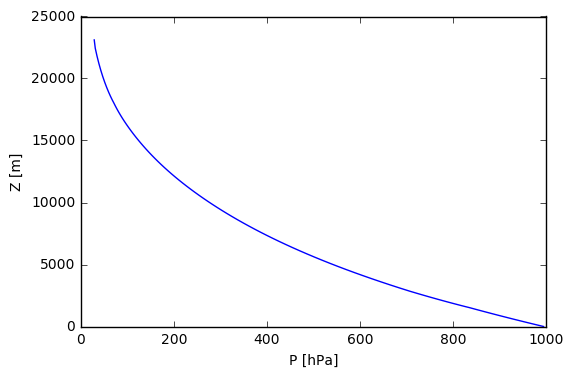

In [69]:
P_mean = np.zeros(array_shape[1])
H_mean = np.zeros(array_shape[1])
for i in range(0, array_shape[1]-1):
    P_mean[i] = np.nanmean(P_wrf[:,i,:,:])
    H_mean[i] = np.nanmean(alt_wrf[:,i,:,:])
    
P_mean[P_mean == 0] = np.nan
plt.plot(P_mean/1e2, H_mean)
plt.xlabel('P [hPa]')
plt.ylabel('Z [m]')
print(H_mean)

## Generate PDFs from observations

In [31]:
num_levels = 40
ws = np.ma.zeros((len(times), num_levels, 81, 111))
ws_all = np.ma.zeros((len(times), num_levels, 81, 111))
minzs = np.ma.zeros((len(times), num_levels, 81, 111))
maxzs = np.ma.zeros((len(times), num_levels, 81, 111))
Zs = np.ma.zeros((len(times), num_levels, 81, 111))
max_w_individual = []
level_individual = []
label_individual = []
count_individual = []
count = 0
n = 0
for time in times:
    ## Get all continous regions of W > 1 m s-1 in 3D w array
    pyart_grid = get_grid_from_dda(time)
    bca = get_bca(pyart_grid)
    w = pyart_grid.fields['upward_air_velocity']['data']
    Z = pyart_grid.fields['reflectivity']['data']
    w_all = deepcopy(w)
    for levels in range(0,num_levels-1):
        w[levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                                   bca > 5*math.pi/6), 
                                                     w[levels] < 1), w[levels])
        Z[levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                                   bca > 5*math.pi/6), 
                                                     w[levels] < 1), Z[levels])
        w_all[levels] = np.ma.masked_where(np.logical_or(bca < math.pi/6,
                                                         bca > 5*math.pi/6), 
                                                         w_all[levels])

    grid_x = pyart_grid.point_x['data']
    grid_y = pyart_grid.point_y['data']
    grid_z = pyart_grid.point_z['data']
    
    # Set mask to exclude data outside of updrafts
    w_temp = deepcopy(w)
    w_temp[~w_temp.mask] = 1
    w_temp[w_temp.mask] = 0
    w_temp.mask = False

    six_connected_structure = [[[0,0,0],
                                [0,1,0],
                                [0,0,0]],
                               [[0,1,0],
                                [1,1,1],
                                [0,1,0]],
                               [[0,0,0],
                                [0,1,0],
                                [0,0,0]]]

    updrafts, num_updrafts = ndimage.measurements.label(w_temp, 
                                                        structure=six_connected_structure)
    
    # Get statistics in continous regions
    index=np.arange(0, num_updrafts + 1)
    max_z = ndimage.measurements.maximum(grid_z, 
                                         labels=updrafts, 
                                         index=index)
    min_z = ndimage.measurements.minimum(grid_z, 
                                         labels=updrafts,
                                         index=index)
   
    deep_cores = np.where(np.logical_and(max_z >= 15000, min_z <= 1000))
    depth = max_z-min_z

    max_z_olevel = np.ma.zeros((81,111))
    min_z_olevel = np.ma.zeros((81,111))
    max_z_level = np.ma.zeros((num_levels, 81,111))
    min_z_level = np.ma.zeros((num_levels, 81,111))
    
    # Find deep convective cores and get max updraft speeds
    for levels in range(0,num_levels-1):
        label_level = updrafts[levels]
        masked_array = np.ma.zeros(updrafts.shape)
        masked_array.mask = True
        w_temp = w[levels]
        
        for labels in range(1, len(max_z)-1):
            indicies = np.ma.where(label_level == labels)                                
            max_z_olevel[indicies] = max_z[labels]
            min_z_olevel[indicies] = min_z[labels]
            
            if(len(indicies[0]) > 0  
               and max_z[labels] >= 5000
               and min_z[labels] <= 1000):
                max_w_individual.append(max(w_temp[indicies]))
                level_individual.append(levels)
                n = n + 1
                label_individual.append(labels)
                count_individual.append(count)
               
        max_z_level[levels] = max_z_olevel
        min_z_level[levels] = min_z_olevel
        
    ws[count] = w
    ws_all[count] = w_all
    minzs[count] = min_z_level
    maxzs[count] = max_z_level 
    Zs[count] = Z
    count = count + 1


max_w_individual = np.array(max_w_individual)
level_individual = np.array(level_individual)
label_individual = np.array(label_individual)
count_individual = np.array(count_individual)
updraft_nos = np.zeros(len(count_individual))
updraft_count = 0
for counts in range(0, max(count_individual)):
    labels = label_individual[count_individual == counts]
    for i in np.unique(labels):
        updraft_nos[np.logical_and(count_individual == counts,
                                   label_individual == i)] = updraft_count
        updraft_count = updraft_count + 1
    
print(str(len(max_w_individual[level_individual == 1])) + ' DCCs found')

# Calculate PDF
mean_w = np.ma.zeros(num_levels)
median_w = np.ma.zeros(num_levels)
max_w = np.ma.zeros(num_levels)
mean_z = np.ma.zeros(num_levels)
median_z = np.ma.zeros(num_levels)
max_z = np.ma.zeros(num_levels)
ninety_w = np.ma.zeros(num_levels)
ninety_five_w = np.ma.zeros(num_levels)
ninety_nine_w = np.ma.zeros(num_levels)
bins = np.arange(0,40,1)
bins_z = np.arange(0,60,1)
h_bins = np.arange(0, 20000, 500)
w_hist = np.ma.zeros((num_levels, len(bins)-1))
w_hist_all = np.ma.zeros((num_levels, len(bins)-1))
dims = ws.shape
total_counts = 0
# Make p.d.f.s 
print(num_levels)
updraft_no = 2
for levels in range(0,num_levels):
    w_level = ws[:,levels,:,:]
    z_level = Zs[:,levels,:,:]
    minz_level = minzs[:,levels,:,:]
    maxz_level = maxzs[:,levels,:,:]
    
    ws_in_core = w_level[~w_level.mask]
    minzs_in_core = minz_level[~w_level.mask]
    maxzs_in_core = maxz_level[~w_level.mask]
    max_w_level = ndimage.measurements.maximum(w[levels],
                                               labels=updrafts[levels],
                                               index=index)
    
    mean_w[levels] = np.ma.mean(max_w_individual[level_individual == levels])
    median_w[levels] = np.ma.median(max_w_individual[level_individual == levels])

    counts, b = np.histogram(ws_in_core, bins=bins)    
    w_hist[levels] = counts

    counts, b = np.histogram(w_level, bins=bins)
    w_hist_all[levels] = counts 
    
    total_counts = total_counts + sum(counts)
    if(len(ws_in_core) > 0):
        ninety_w[levels] = np.percentile(max_w_individual[level_individual == levels], 90)
        ninety_five_w[levels] = np.percentile(max_w_individual[level_individual == levels], 95)
        ninety_nine_w[levels] = np.percentile(max_w_individual[level_individual == levels], 99)
    else:
        ninety_five_w[levels] = float('nan')
        ninety_nine_w[levels] = float('nan')
        ninety_w[levels] = float('nan')

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:140: RuntimeWarning: invalid value encountered in divide
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:141: RuntimeWarning: invalid value encountered in arccos
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:142: RuntimeWarning: invalid value encountered in divide
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: invalid value encountered in less
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: invalid value encountered in less
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: 

40 DCCs found
40


## Generate PDFs from WRF model run

In [57]:
max_w_individual = []
level_individual = []
label_individual = []
count_individual = []
height_individual = []
height = np.zeros(array_shape[1:])

for i in range(0, array_shape[0]):
    ## Get all continous regions of W > 1 m s-1 in 3D w array
    w = np.ma.array(W_wrf[i])
    
    w_all = deepcopy(w)
    for levels in range(0,array_shape[1]):
        w[levels] = np.ma.masked_where(w[levels] < 1, w[levels])
        w_all[levels] = W_wrf[i,levels]
        height[levels] = alt_wrf[i,levels]
        

    grid_z = height
    
    # Set mask to exclude data outside of updrafts
    w_temp = deepcopy(w)
    w_temp[~w_temp.mask] = 1
    w_temp[w_temp.mask] = 0
    w_temp.mask = False

    six_connected_structure = [[[0,0,0],
                                [0,1,0],
                                [0,0,0]],
                               [[0,1,0],
                                [1,1,1],
                                [0,1,0]],
                               [[0,0,0],
                                [0,1,0],
                                [0,0,0]]]

    updrafts, num_updrafts = ndimage.measurements.label(w_temp, 
                                                        structure=six_connected_structure)
    
    # Get statistics in continous regions
    index=np.arange(0, num_updrafts + 1)
    max_z = ndimage.measurements.maximum(grid_z, 
                                         labels=updrafts, 
                                         index=index)
    min_z = ndimage.measurements.minimum(grid_z, 
                                         labels=updrafts,
                                         index=index)
    deep_cores = np.where(np.logical_and(max_z >= 15000, min_z <= 1000))
    depth = max_z-min_z
    max_z_olevel = np.ma.zeros((array_shape[2],array_shape[3]))
    min_z_olevel = np.ma.zeros((array_shape[2],array_shape[3]))
    max_z_level = np.ma.zeros((array_shape[1],array_shape[2],array_shape[3]))
    min_z_level = np.ma.zeros((array_shape[1],array_shape[2],array_shape[3]))
    
    # Find deep convective cores and get max updraft speeds
    for levels in range(0,array_shape[1]):
        label_level = updrafts[levels]
        masked_array = np.ma.zeros(updrafts.shape)
        masked_array.mask = True
        w_temp = w[levels]
        height_temp = height[levels]
        for labels in range(1, len(max_z)-1):
            indicies = np.ma.where(label_level == labels)                                
            max_z_olevel[indicies] = max_z[labels]
            min_z_olevel[indicies] = min_z[labels]
            
            if(len(indicies[0]) > 0  
               and max_z[labels] >= 5000
               and min_z[labels] <= 1000):
                max_w_individual.append(max(w_temp[indicies]))
                level_individual.append(levels)
                n = n + 1
                label_individual.append(labels)
                count_individual.append(count)
                height_individual.append(np.mean(height_temp[indicies]))
               
        max_z_level[levels] = max_z_olevel
        min_z_level[levels] = min_z_olevel
        
    count = count + 1

max_w_individual = np.array(max_w_individual)
level_individual = np.array(level_individual)
label_individual = np.array(label_individual)
count_individual = np.array(count_individual)
height_individual = np.array(height_individual)
updraft_nos = np.zeros(len(count_individual))
updraft_count = 0
print(count_individual)
for counts in range(0, max(count_individual)):
    labels = label_individual[count_individual == counts]
    for i in np.unique(labels):
        updraft_nos[np.logical_and(count_individual == counts,
                                   label_individual == i)] = updraft_count
        updraft_count = updraft_count + 1
    
print(str(len(max_w_individual[level_individual == 1])) + ' DCCs found')

# Calculate PDF
num_levels = array_shape[1]
mean_w_wrf = np.ma.zeros(num_levels)
median_w_wrf = np.ma.zeros(num_levels)
max_w_wrf = np.ma.zeros(num_levels)
height_level = np.ma.zeros(num_levels)
ninety_w_wrf = np.ma.zeros(num_levels)
ninety_five_w_wrf = np.ma.zeros(num_levels)
ninety_nine_w_wrf = np.ma.zeros(num_levels)
bins = np.arange(0,40,1)
bins_z = np.arange(0,60,1)
h_bins = np.arange(0, 20000, 500)
w_hist = np.ma.zeros((num_levels, len(bins)-1))
w_hist_all = np.ma.zeros((num_levels, len(bins)-1))
dims = ws.shape
total_counts = 0
# Make p.d.f.s 
print(num_levels)
updraft_no = 2
for levels in range(0,array_shape[1]):
    mean_w_wrf[levels] = np.ma.mean(max_w_individual[level_individual == levels])
    median_w_wrf[levels] = np.ma.median(max_w_individual[level_individual == levels])
    height_level[levels] = np.nanmean(height_individual[level_individual == levels])
    counts, b = np.histogram(ws_in_core, bins=bins)    
    w_hist[levels] = counts

    counts, b = np.histogram(w_level, bins=bins)
    w_hist_all[levels] = counts 
    
    total_counts = total_counts + sum(counts)
    if(len(np.where(level_individual == levels)) > 0):
        ninety_w_wrf[levels] = np.nanpercentile(max_w_individual[level_individual == levels], 90)
        ninety_five_w_wrf[levels] = np.nanpercentile(max_w_individual[level_individual == levels], 95)
        ninety_nine_w_wrf[levels] = np.nanpercentile(max_w_individual[level_individual == levels], 99)
    else:
        ninety_five_w_wrf[levels] = float('nan')
        ninety_nine_w_wrf[levels] = float('nan')
        ninety_w_wrf[levels] = float('nan')

[150 150 150 ..., 167 167 167]
16 DCCs found
97


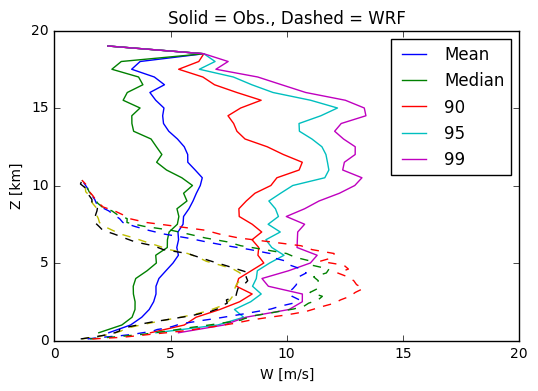

In [72]:
z_levels = np.arange(0,20,0.5)
h1 = plt.plot(mean_w, z_levels, label="Median")
h2 = plt.plot(median_w, z_levels, label="Mean")
h3 = plt.plot(ninety_w, z_levels, label="90")
h4 = plt.plot(ninety_five_w, z_levels, label="95")
h5 = plt.plot(ninety_nine_w, z_levels, label="99")
h6 = plt.plot(mean_w_wrf, height_level/1e3, label="Median WRF", linestyle='--')
h7 = plt.plot(median_w_wrf, height_level/1e3, label="Mean WRF", linestyle='--')
h3 = plt.plot(ninety_w_wrf, height_level/1e3, label="90", linestyle='--')
h4 = plt.plot(ninety_five_w_wrf, height_level/1e3, label="95", linestyle='--')
h5 = plt.plot(ninety_nine_w_wrf, height_level/1e3, label="99", linestyle='--')
plt.legend(['Mean', 'Median', '90','95','99'])
plt.xlabel('W [m/s]')
plt.ylabel('Z [km]')
plt.xlim([0,20])
plt.title('Solid = Obs., Dashed = WRF')